# Kmeans on wavelet transforms from concatenated session

In [125]:
prefix = '/home/ines/repositories/'
# prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [126]:
""" 
IMPORTS
"""
import os
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
from kneed import KneeLocator
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from one.api import ONE

# Get my functions
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files
functions_path =  prefix + 'representation_learning_variability/Functions/'
os.chdir(functions_path)
from data_processing import save_and_log
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//4_analyses/5_clustering_analyses//'
os.chdir(functions_path)
from clustering_functions import GMM_neg_log_likelihood

one = ONE(mode='remote')

## Load supersession

In [137]:
# Load trial clsuters
results_path = prefix + 'representation_learning_variability/Models/Sub-trial/2_fit_models/Wavelets/'
filename = str(results_path + 'supersession_wavelets_paw09-03-2025')
super_session = np.load(open(filename, 'rb'))

## k selection with GMM model comparison

In [15]:
repeats = 5
components = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
LLs = np.zeros((repeats, len(components))) * np.nan
for r in range(repeats):    
    # Compute log likelihood of a GMM model with different components
    LLs[r, :] = GMM_neg_log_likelihood(super_session.copy(), components)
kneedle = KneeLocator(components[1:], np.nanmean(LLs, axis=0)[1:], curve="convex", direction="decreasing")
kneedle = KneeLocator(components, np.nanmean(LLs, axis=0), curve="convex", direction="decreasing")
optimal_k = kneedle.knee

In [142]:
optimal_k

6

In [17]:
file_to_save = LLs.copy()
filename = 'LLs_GMM_1_11_components'
save_path = '/home/ines/repositories/representation_learning_variability/Models/Maths intuitions/Wavelets/'
file_format = 'npy'
script_name = 'kmeans_supersession.ipynb'
metadata = save_and_log(file_to_save, filename, file_format, save_path, script_name)

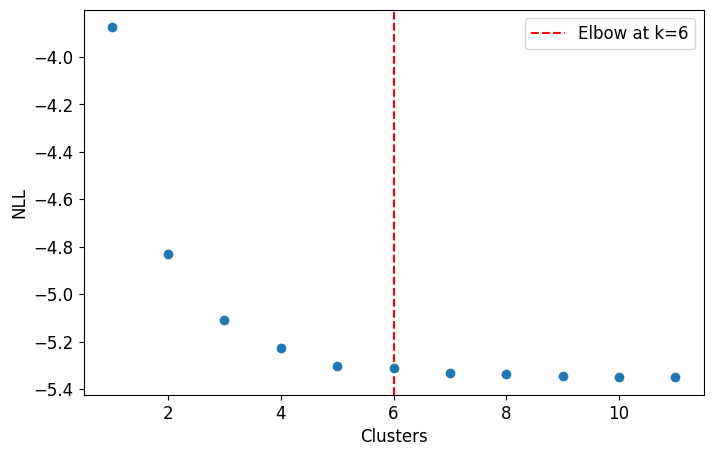

In [143]:
# Plot
fig, ax = plt.subplots(figsize=(8, 5))
# plt.plot(components[1:], LLs[0][1:], 'bo-', label="Model Fit")
plt.errorbar(components, np.nanmean(LLs, axis=0), np.nanstd(LLs, axis=0)/np.sqrt(repeats), linestyle='None', marker='o')
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Elbow at k={optimal_k}')
plt.xlabel("Clusters")
plt.ylabel("NLL")
plt.legend()
plt.show()

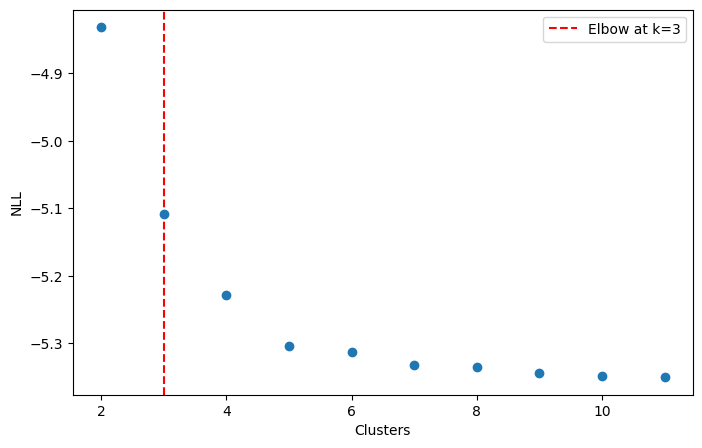

In [12]:
# Plot
fig, ax = plt.subplots(figsize=(8, 5))
# plt.plot(components[1:], LLs[0][1:], 'bo-', label="Model Fit")
plt.errorbar(components[1:], np.nanmean(LLs, axis=0)[1:], np.nanstd(LLs, axis=0)[1:]/np.sqrt(repeats), linestyle='None', marker='o')
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Elbow at k={optimal_k}')
plt.xlabel("Clusters")
plt.ylabel("NLL")
plt.legend()
plt.show()

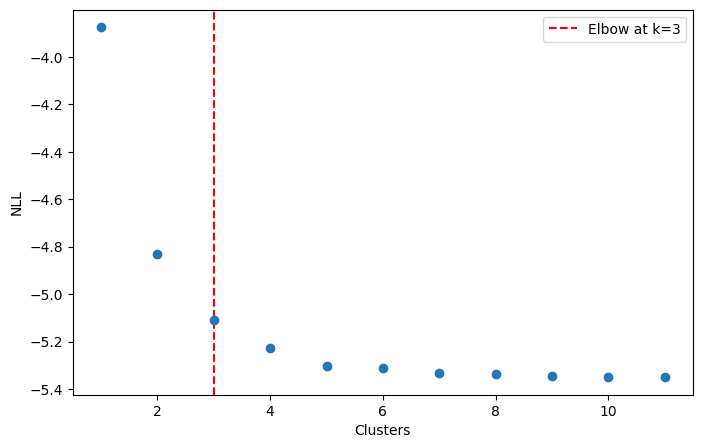

In [13]:
kneedle = KneeLocator(components, np.nanmean(LLs, axis=0), curve="convex", direction="decreasing")
optimal_k = kneedle.knee

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
# plt.plot(components[1:], LLs[0][1:], 'bo-', label="Model Fit")
plt.errorbar(components, np.nanmean(LLs, axis=0), np.nanstd(LLs, axis=0)/np.sqrt(repeats), linestyle='None', marker='o')
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Elbow at k={optimal_k}')
plt.xlabel("Clusters")
plt.ylabel("NLL")
plt.legend()
plt.show()

### kMeans on supersession

In [348]:
optimal_k = 6
kmeans = KMeans(n_clusters=optimal_k, random_state=2024)
kmeans.fit(super_session.copy())
centroids = kmeans.cluster_centers_

In [6]:
# Save centroid results
file_to_save = centroids.copy()
filename = str('centroids_supersession_wavelets_k_'+str(optimal_k))
save_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/Wavelets/'
file_format = 'npy'
script_name = 'kmeans_supersession.ipynb'
metadata = save_and_log(file_to_save, filename, file_format, save_path, script_name)

### Predict clusters of unseen data and save

In [145]:
# LOAD DATA
bin_size = 0.017

data_path =prefix + 'representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v6_21Jul2025/' + str(bin_size) + '/'
all_files = os.listdir(data_path)
design_matrices = [item for item in all_files if 'design_matrix' in item and 'standardized' not in item]
idxs, mouse_names = idxs_from_files(design_matrices, bin_size)


In [146]:
# Identify sessions availableto process
sessions_to_process = []
for m, mat in enumerate(idxs):
    mouse_name = mat[37:]
    session = mat[:36]
    sessions_to_process.append((mouse_name, session))

In [147]:
from joblib import Parallel, delayed
from scipy.fftpack import fft, ifft, fftshift
from scipy import stats


def morlet_conj_ft(omega_vals, omega0):
    """
    Computes the conjugate Fourier transform of the Morlet wavelet.
    
    Parameters:
    - w: Angular frequency values (array or scalar)
    - omega0: Dimensionless Morlet wavelet parameter
    
    Returns:
    - out: Conjugate Fourier transform of the Morlet wavelet
    """
    
    return np.pi**(-1/4) * np.exp(-0.5 * (omega_vals - omega0)**2)


def fast_wavelet_morlet_convolution_parallel(x, f, omega0, dt):
    """
    Fast Morlet wavelet transform using parallel computation.

    Args:
        x (array): 1D array of projection values to transform.
        f (array): Center frequencies of the wavelet frequency channels (Hz).
        omega0 (float): Dimensionless Morlet wavelet parameter.
        dt (float): Sampling time (seconds).

    Returns:
        amp (array): Wavelet amplitudes.
        W (array): Wavelet coefficients (complex-valued, optional).
    """
    N = len(x)
    L = len(f)
    amp = np.zeros((L, N))
    Q = np.zeros((L, N))

    # Ensure N is even
    if N % 2 == 1:
        x = np.append(x, 0)
        N += 1
        test = True
    else:
        test = False

    # Add zero padding to x
    # Zero padding serves to compensate for the fact that the kernel does not have the same size as 
    # 
    x = np.concatenate((np.zeros(N // 2), x, np.zeros(N // 2)))
    M = N
    N = len(x)

    # Compute scales
    scales = (omega0 + np.sqrt(2 + omega0**2)) / (4 * np.pi * f)
    # angular frequencies to compute FT for (depends on sampling frequency); is as long as N 
    omega_vals = 2 * np.pi * np.arange(-N // 2, N // 2) / (N * dt)  

    # Fourier transform of x; shift folds it around zero so that it is more interpretable (frequencies at the right of nyquist become negative)
    x_hat = fftshift(fft(x))

    # Index for truncation to recover the actual x without padding
    if test:
        idx = np.arange(M // 2, M // 2 + M - 1)
    else:
        idx = np.arange(M // 2, M // 2 + M)

    # Function for parallel processing
    def process_frequency(i):
        # Take the Morlet conjugate of the Fourier transform
        m = morlet_conj_ft(-omega_vals * scales[i], omega0)
        # Convolution on the Fourier domain (as opposed to time domain in DWT)
        conv = m * x_hat
        # Inverse Fourier transform (normalized?)
        # q are the wavelet coefficients; normalized to ensure the energy of the wavelet is preserved across different scales
        q = ifft(conv) * np.sqrt(scales[i])
        # Recover q without padding
        q = q[idx]
        amp_row = np.abs(q) * np.pi**-0.25 * np.exp(0.25 * (omega0 - np.sqrt(omega0**2 + 2))**2) / np.sqrt(2 * scales[i])
        return amp_row, q

    # Parallel processing
    results = Parallel(n_jobs=-1)(delayed(process_frequency)(i) for i in range(L))

    for i, (amp_row, q) in enumerate(results):
        amp[i, :] = amp_row
        Q[i, :] = q

    return amp, Q, x_hat

In [349]:
# Wavelet decomposition
f = np.array([.25, .5, 1, 2, 4, 8, 16])
omega0 = 5

paw_vars = ['l_paw_x', 'l_paw_y', 'r_paw_x', 'r_paw_y']

wavelet_vars = ['l_paw_x0.5', 'l_paw_x1.0', 'l_paw_x2.0', 'l_paw_x4.0', 'l_paw_x8.0', 
                'l_paw_y0.5', 'l_paw_y1.0', 'l_paw_y2.0', 'l_paw_y4.0', 'l_paw_y8.0', 
                'r_paw_x0.5', 'r_paw_x1.0', 'r_paw_x2.0', 'r_paw_x4.0', 'r_paw_x8.0',
                'r_paw_y0.5', 'r_paw_y1.0', 'r_paw_y2.0', 'r_paw_y4.0', 'r_paw_y8.0']
var_interest = ['l_paw_x', 'l_paw_y', 'r_paw_x', 'r_paw_y', 
                'l_paw_x0.5', 'l_paw_x1.0', 'l_paw_x2.0', 'l_paw_x4.0', 'l_paw_x8.0', 
                'l_paw_y0.5', 'l_paw_y1.0', 'l_paw_y2.0', 'l_paw_y4.0', 'l_paw_y8.0', 
                'r_paw_x0.5', 'r_paw_x1.0', 'r_paw_x2.0', 'r_paw_x4.0', 'r_paw_x8.0',
                'r_paw_y0.5', 'r_paw_y1.0', 'r_paw_y2.0', 'r_paw_y4.0', 'r_paw_y8.0']

for m, mat in enumerate(sessions_to_process[:1]):

    mouse_name = mat[0]
    session = mat[1]
    fit_id = str(mouse_name+session)
    filename = data_path + "design_matrix_" + str(session) + '_'  + mouse_name
    design_matrix = pd.read_parquet(filename)
    
    # TODO: this step should not be here later on
    for v, var in enumerate(paw_vars):
        
        var_array = np.array(design_matrix[var])
        not_nan = ~np.isnan(var_array)
        clean_array = np.array(stats.zscore(design_matrix[var][not_nan]))
        # Wavelet decomposition of wheel velocity
        dt = np.round(np.mean(np.diff(design_matrix['Bin'])), 3)
        amp, Q, x_hat = fast_wavelet_morlet_convolution_parallel(clean_array, f, omega0, dt)

        # Wavelet transforms
        for i, frequency in enumerate(f):
            # Create new column with frequency
            design_matrix[str(var+str(frequency))] = design_matrix['Bin'] * np.nan
            design_matrix[str(var+str(frequency))] = np.nan
            design_matrix[str(var+str(frequency))][not_nan] = amp[i, :]
            

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is 

In [350]:
    zscored_data = design_matrix[var_interest].copy()
    zscored_data[paw_vars] = stats.zscore(np.array(zscored_data[paw_vars]), axis=0, nan_policy='omit') 
    var_array = np.array(zscored_data)
    not_nan = ~np.isnan(var_array).any(axis=1)
    data = var_array[not_nan, :]
        
    """ Compute clusters based on supersession centroids """
    # Compute distances between full dataset and trained centroids
    distances = cdist(data, centroids, metric='euclidean')
    # Assign each point to the nearest centroid
    states = np.argmin(distances, axis=1)
    
    design_matrix['paw_states'] = np.nan
    design_matrix['paw_states'][not_nan] = states

/tmp/ipykernel_22101/2420315918.py:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  design_matrix['paw_states'][not_nan] = states


In [351]:
zscored_data = design_matrix[var_interest].copy()
zscored_data[paw_vars] = stats.zscore(np.array(zscored_data[paw_vars]), axis=0, nan_policy='omit') 
zscored_data['paw_states'] = design_matrix['paw_states']

paw_vars = ['l_paw_x', 'l_paw_y', 'r_paw_x', 'r_paw_y']
paw_df = pd.melt(zscored_data, id_vars=['paw_states'], value_vars=paw_vars)

wavelet_df = pd.melt(zscored_data, id_vars=['paw_states'], value_vars=wavelet_vars)

<Axes: xlabel='paw_states', ylabel='value'>

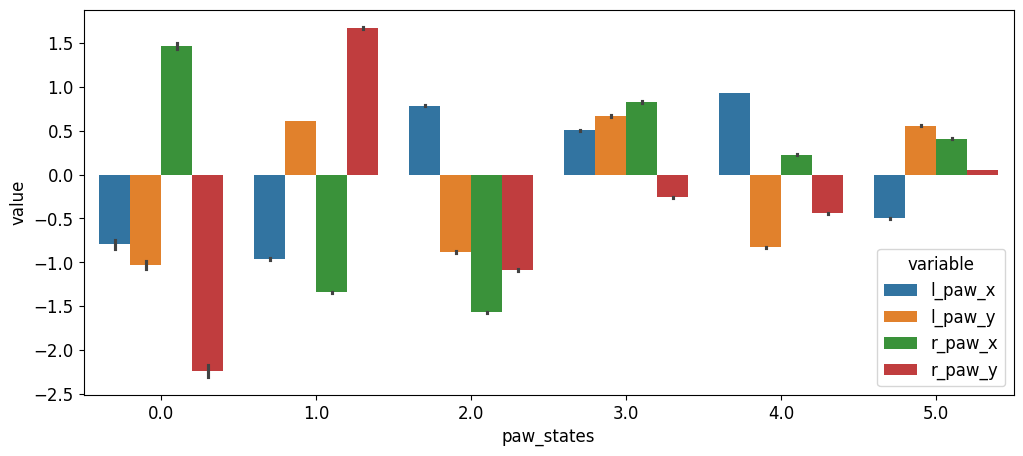

In [352]:
plt.figure(figsize=[12, 5])
sns.barplot(x='paw_states', y='value', hue='variable', data=paw_df)

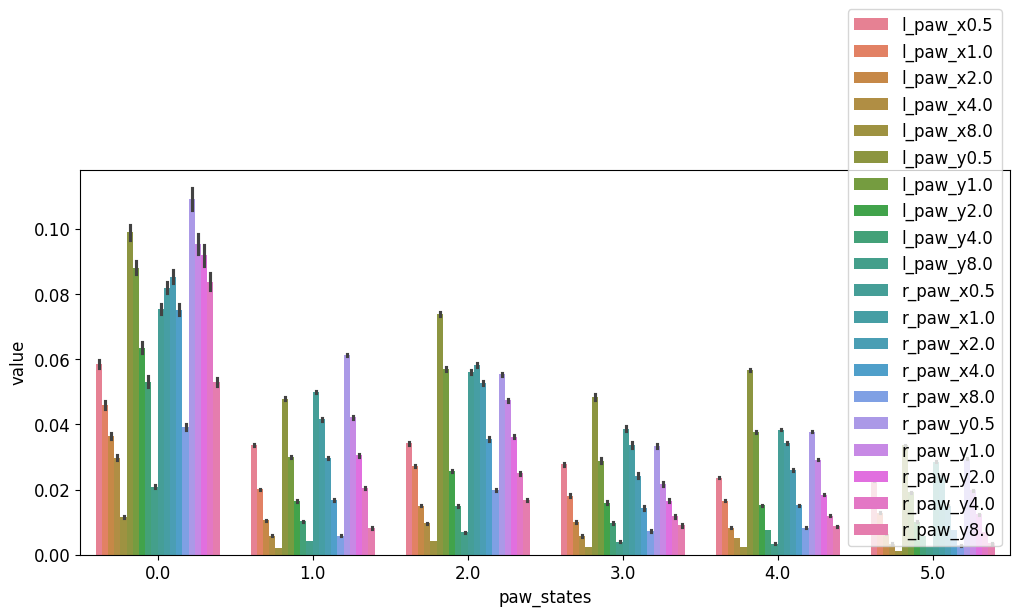

In [353]:
plt.figure(figsize=[12, 5])
sns.barplot(x='paw_states', y='value', hue='variable', data=wavelet_df)
plt.legend()

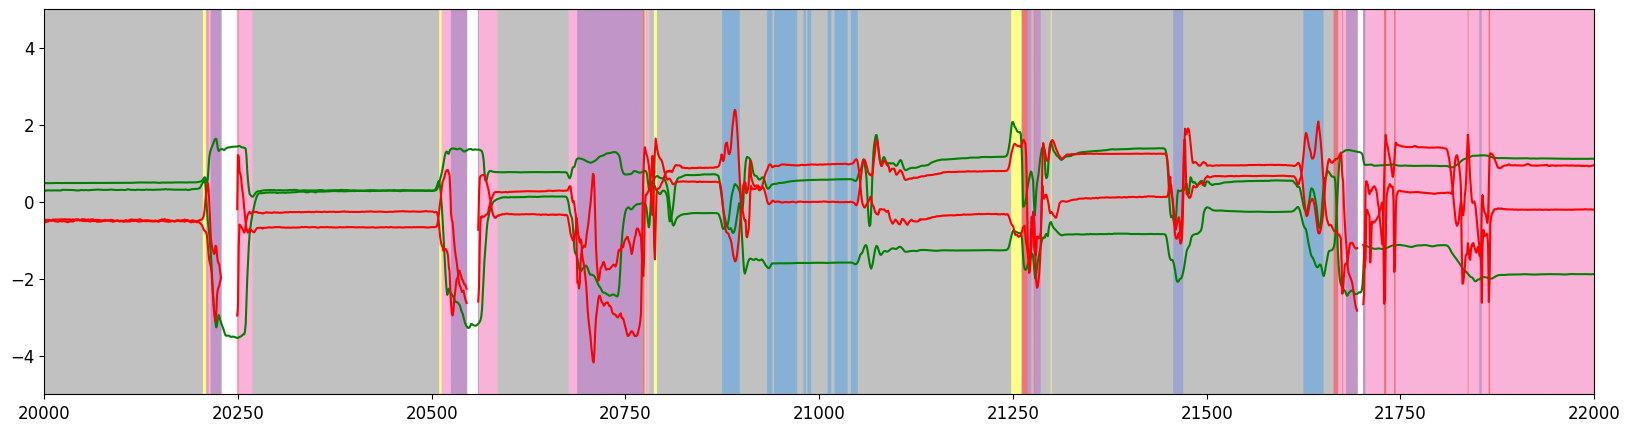

In [354]:

fig, ax = plt.subplots(ncols=1 , nrows=1, sharex=False, sharey=False, figsize=[20, 5])
plt.rc('font', size=12)
init = 000
# ax.plot(design_matrix.loc[design_matrix['Bin']>=init, 'avg_wheel_vel'].reset_index(), color='black')
ax.plot(stats.zscore(design_matrix.loc[design_matrix['Bin']>=init, 'l_paw_x'].reset_index()['l_paw_x'], nan_policy='omit'), color='green')
ax.plot(stats.zscore(design_matrix.loc[design_matrix['Bin']>=init, 'l_paw_y'].reset_index()['l_paw_y'], nan_policy='omit'), color='green')
ax.plot(stats.zscore(design_matrix.loc[design_matrix['Bin']>=init, 'r_paw_x'].reset_index()['r_paw_x'], nan_policy='omit'), color='red')
ax.plot(stats.zscore(design_matrix.loc[design_matrix['Bin']>=init, 'r_paw_y'].reset_index()['r_paw_y'], nan_policy='omit'), color='red')
attach_array = np.arange(0, optimal_k, 1)
ax.imshow(np.concatenate([design_matrix.loc[design_matrix['Bin']>=init, 'paw_states']])[None,:],
            extent=(0, len(np.concatenate([design_matrix.loc[design_matrix['Bin']>=init, 'paw_states']])), -10, 10),
            aspect="auto",
            alpha=0.6,
            cmap='Set1')  # 
init=20000
plt.xlim([init, init+2000])
plt.ylim([-5, 5])
plt.show()

Do I need to remove NaNs? and shorten like in the 